In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import A2C

from data_util import *
# from run_experiments import *

In [27]:
# input parameters
TICKER = 'XLE' # ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLV']
INITIAL_PORTFOLIO_VALUE = 1000
BORROWING = True
LONG_ONLY = False

In [23]:
# load training data
train_data_path = '../data/{}_train.csv'.format(TICKER.lower())
train_data = pd.read_csv(train_data_path)
env = SingleStockTradingEnv(train_data_path,
                            engineer_features, 
                            initial_value=INITIAL_PORTFOLIO_VALUE,
                            borrowing=BORROWING,
                            long_only=LONG_ONLY)

# load validation data
val_data_path = '../data/{}_validation.csv'.format(TICKER.lower())
val_data = pd.read_csv(val_data_path)
val_data['Date'] = pd.to_datetime(val_data['Date'])

Goal reached! reward= 1.4799960000000283
1374.294333999998
2.374294333999998 1.8415927711312476


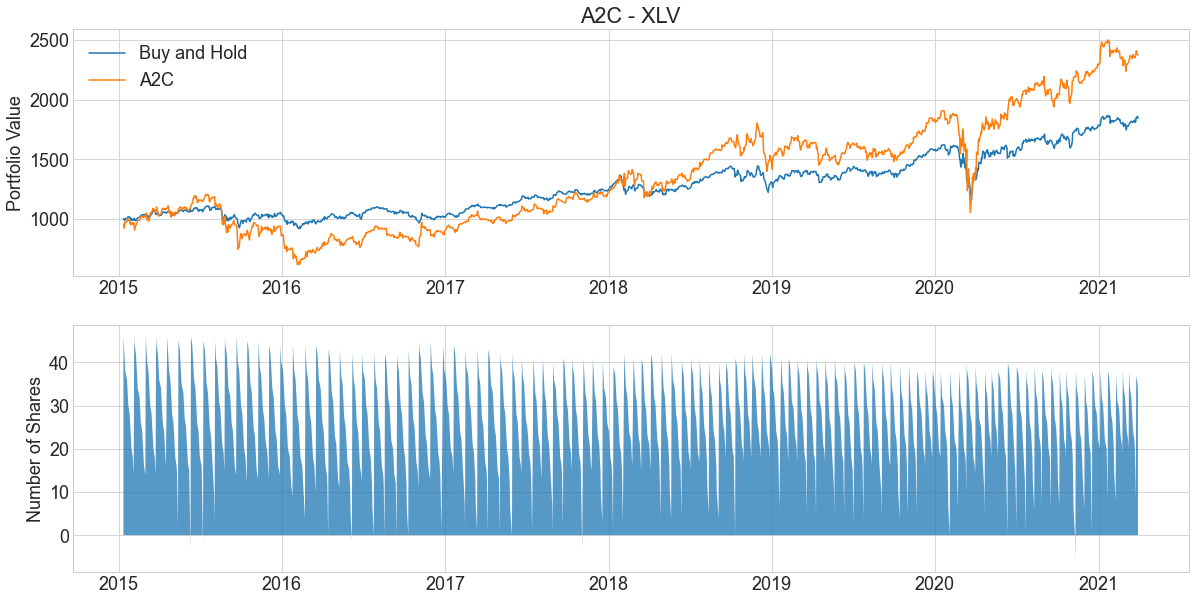

In [24]:
# create and train agent
# agent = A2C('MlpPolicy', env, gamma=0.1)
# env.reset()
# agent.learn(env.data.shape[0]) # go through whole history based on each training run

agent = A2C.load('checkpoints/{}_rl_no_restrictions'.format(TICKER.lower()))
rl_portfolio_values, rl_agent_holdings, rl_agent_actions, rl_goal_num_shares, rl_fig = evaluate(agent, 
                                                                                                TICKER,
                                                                                                val_data, 
                                                                                                INITIAL_PORTFOLIO_VALUE, 
                                                                                                BORROWING, 
                                                                                                LONG_ONLY, 
                                                                                                use_gp=False, 
                                                                                                plot=True, 
                                                                                                show_plots=False,
                                                                                                save_plots=False, 
                                                                                                env_type='no_restrictions')

In [25]:
# save agent and figure
# rl_checkpoint_path = 'checkpoints/{}_rl_no_restrictions'.format(TICKER.lower())
# agent.save(rl_checkpoint_path)

# rl_fig.savefig('figures/{}_rl_base_no_restrictions.pdf'.format(TICKER.lower()), bbox_inches='tight')

## Running comparison plots and getting stats

In [35]:
import torch

from model import *

In [138]:
TICKER = 'XLV' # ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLV']
INITIAL_PORTFOLIO_VALUE = 1000
BORROWING = True
LONG_ONLY = False

In [139]:
# initialize structures for evaluation
train_data_path = '../data/{}_train.csv'.format(TICKER.lower())
val_data_path = '../data/{}_validation.csv'.format(TICKER.lower())
train_data = pd.read_csv(train_data_path)
val_data = pd.read_csv(val_data_path)
val_data['Date'] = pd.to_datetime(val_data['Date'])
env = SingleStockTradingEnv(train_data_path, 
                            engineer_features,
                            initial_value=INITIAL_PORTFOLIO_VALUE, 
                            borrowing=BORROWING,
                            long_only=LONG_ONLY)

Goal reached! reward= 1.4799960000000283
1374.294333999998
2.374294333999998 1.8415927711312476


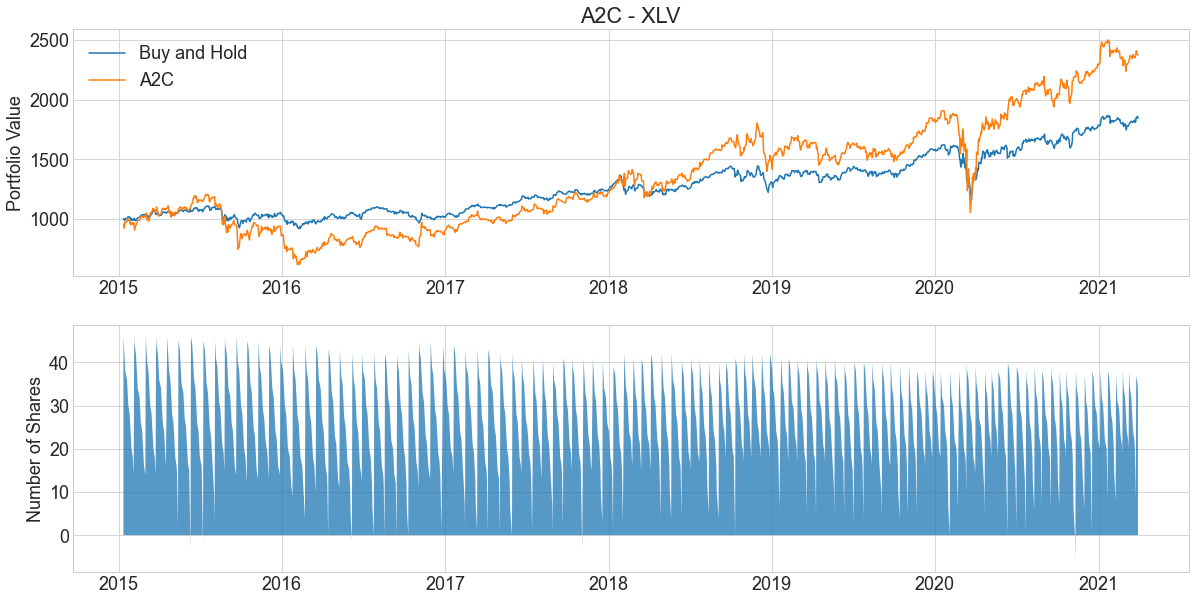

In [140]:
# run evaluation for just RL agent
rl_checkpoint_path = 'checkpoints/{}_rl_no_restrictions'.format(TICKER.lower())
a2c = A2C.load(rl_checkpoint_path)
rl_portfolio_values, rl_agent_holdings, rl_agent_actions, rl_goal_num_shares, rl_fig = evaluate(a2c, 
                                                                                                TICKER,
                                                                                                val_data, 
                                                                                                INITIAL_PORTFOLIO_VALUE, 
                                                                                                BORROWING, 
                                                                                                LONG_ONLY, 
                                                                                                use_gp=False, 
                                                                                                plot=True, 
                                                                                                show_plots=False,
                                                                                                save_plots=False, 
                                                                                                env_type='no_restrictions')

In [141]:
# get features for GP's
lookback = 5
train_features = engineer_features(train_data, lookback=lookback)

# turn data in dataframes into model inputs
X_train = torch.Tensor(train_features.drop(['Date', 'Volume', 'Returns', 'Close', f'Open -{lookback}'], axis=1).values)
y_train = torch.Tensor(train_features['Returns'].values)

gp_params = {'n_train': 20,
             'training_iter': 10,
             'cvar_limit': -5, # maximum loss tolerance %
             'gp_limit': 0.3, # predicted magnitude of GPR such that GP takes over
             'data': {'X_train': X_train[-20:], 'y_train': y_train[-20:]} # last month's worth of data?
             }

Goal reached! reward= 1.4799960000000283
1513.1907960000071
2.513190796000007 1.8415927711312476


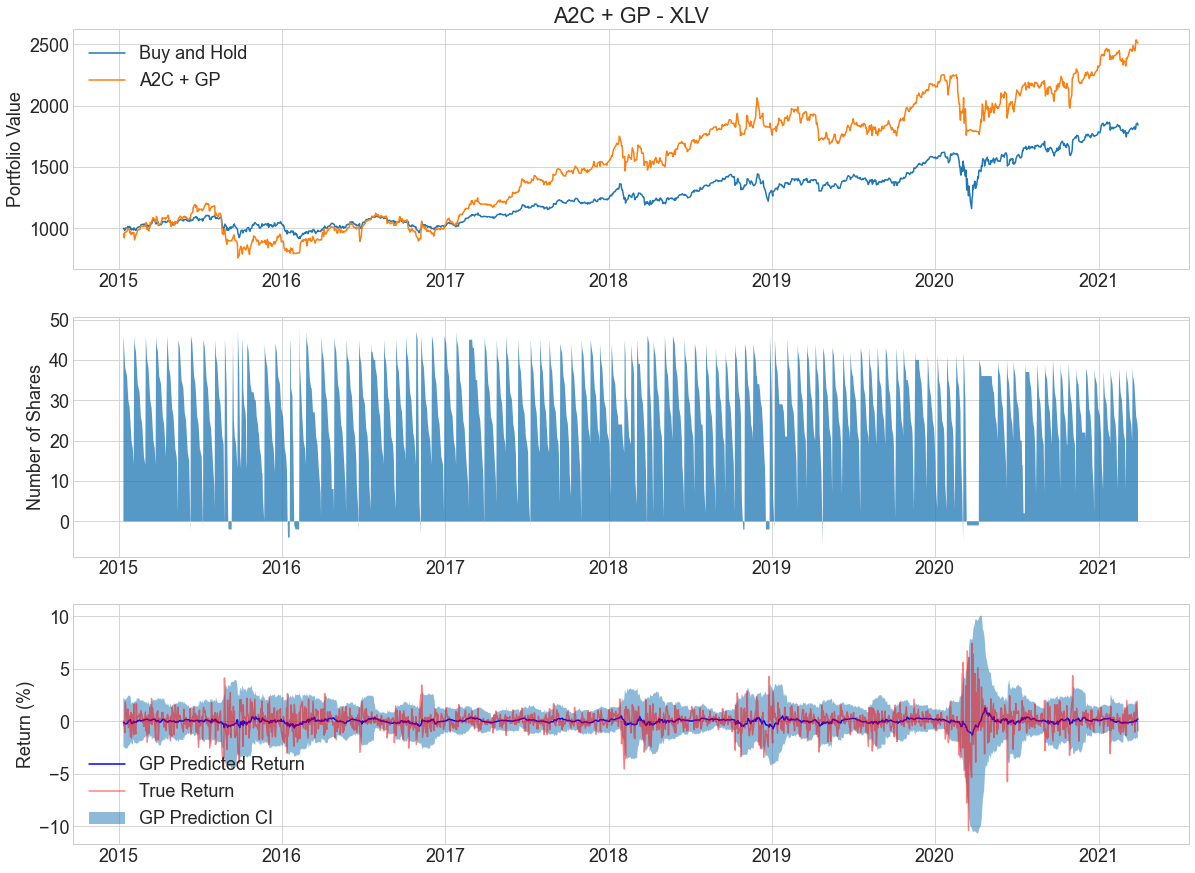

In [142]:
# run evaluation for RL w/ GP agent
a2c_gp = TradingAgent(use_gp=True, gp_params=gp_params, policy='MlpPolicy', env=env)
a2c_gp.load(rl_path=rl_checkpoint_path)
a2c_gp.learn(5000)
a2c_gp.save(rl_path='checkpoints/{}_a2c_gp_no_restrictions_rl'.format(TICKER.lower()), 
            gp_path='checkpoints/{}_a2c_gp_no_restrictions_gp'.format(TICKER.lower()))
gp_portfolio_values, gp_agent_holdings, gp_agent_actions, gp_goal_num_shares, gp_fig = evaluate(a2c_gp, 
                                                                                                TICKER,
                                                                                                val_data, 
                                                                                                INITIAL_PORTFOLIO_VALUE, 
                                                                                                BORROWING, 
                                                                                                LONG_ONLY, 
                                                                                                use_gp=True, 
                                                                                                plot=True, 
                                                                                                show_plots=False,
                                                                                                save_plots=False, 
                                                                                                env_type='no_restrictions')

In [143]:
# Calculate and output Sharpe ratios (assume risk-free rate is 0)
base_log_returns = np.diff(np.log(val_data['Adj Close']))
base_daily_vol = np.std(base_log_returns)
base_sharpe = np.sqrt(252) * np.mean(base_log_returns) / base_daily_vol

if TICKER == 'XLE':
    rl_adj_portfolio_values = rl_portfolio_values.copy()
    for idx in np.where(np.array(rl_portfolio_values) < 0)[0]:
        rl_adj_portfolio_values[idx] = 0.01
    rl_log_returns = np.diff(np.log(rl_adj_portfolio_values))
else:
    rl_log_returns = np.diff(np.log(rl_portfolio_values))
rl_daily_vol = np.std(rl_log_returns)
rl_sharpe = np.sqrt(252) * np.mean(rl_log_returns) / rl_daily_vol

gp_log_returns = np.diff(np.log(gp_portfolio_values))
gp_daily_vol = np.std(gp_log_returns)
gp_sharpe = np.sqrt(252) * np.mean(gp_log_returns) / gp_daily_vol

print('Base: {:.4f}, {:.4f}\tA2C: {:.4f}, {:.4f}\tA2C+GP: {:.4f}, {:.4f}'.format(base_sharpe, base_daily_vol,
                                                                                 rl_sharpe, rl_daily_vol,
                                                                                 gp_sharpe, gp_daily_vol))

Base: 0.5534, 0.0116	A2C: 0.4367, 0.0212	A2C+GP: 0.5752, 0.0171


In [144]:
results = pd.DataFrame({'Date': val_data['Date'][6:], 
                        'Buy and Hold': val_data['Adj Close'][6:].values, 
                        'A2C': rl_portfolio_values, 
                        'A2C + GP': gp_portfolio_values})
results.reset_index(drop=True, inplace=True)
for col in results.drop('Date', axis=1).columns:
    roll_max = results[col].rolling(252, min_periods=1).max()
    daily_drawdown = results[col]/roll_max - 1.0
    results[col + ' Drawdown'] = daily_drawdown
results.head()

,Date,Buy and Hold,A2C,A2C + GP,Buy and Hold Drawdown,A2C Drawdown,A2C + GP Drawdown
0,2015-01-12,63.292881,955.379908,955.379908,0.000000,0.000000,0.000000
1,2015-01-13,63.013565,949.700346,949.700346,-0.004413,-0.005945,-0.005945
2,2015-01-14,62.914444,921.984446,921.984446,-0.005979,-0.034955,-0.034955
3,2015-01-15,62.238628,968.364624,968.364624,-0.016657,0.000000,0.000000
4,2015-01-16,63.410061,968.584624,968.584624,0.000000,0.000000,0.000000


In [145]:
results.min()

Date                     2015-01-12 00:00:00
Buy and Hold                       58.048985
A2C                               616.185315
A2C + GP                          759.675074
Buy and Hold Drawdown              -0.284043
A2C Drawdown                       -0.488856
A2C + GP Drawdown                  -0.369827
dtype: object

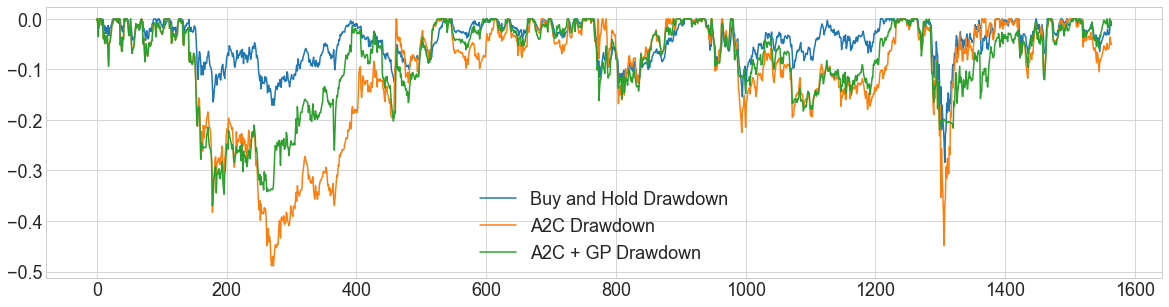

In [146]:
fig = results[['Buy and Hold Drawdown', 'A2C Drawdown', 'A2C + GP Drawdown']].plot(figsize=(20,5))
plt.show()

In [147]:
results.to_csv('../data/{}_results.csv'.format(TICKER.lower()), index=False)
fig.figure.savefig('figures/{}_drawdowns_comparison.pdf'.format(TICKER.lower()))

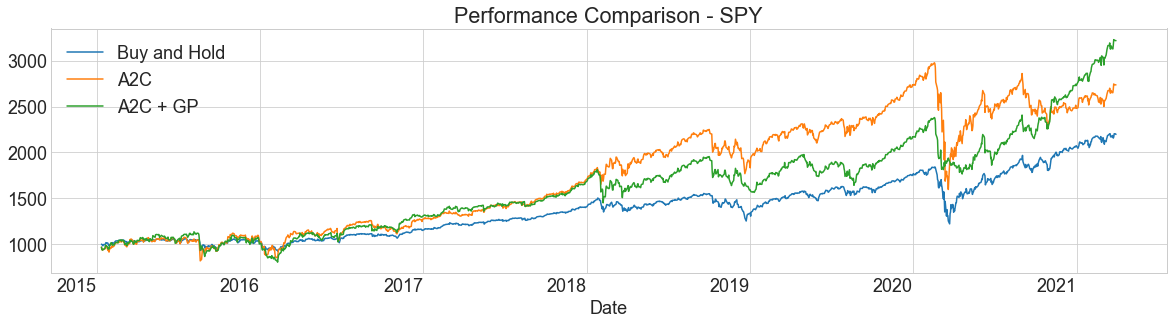

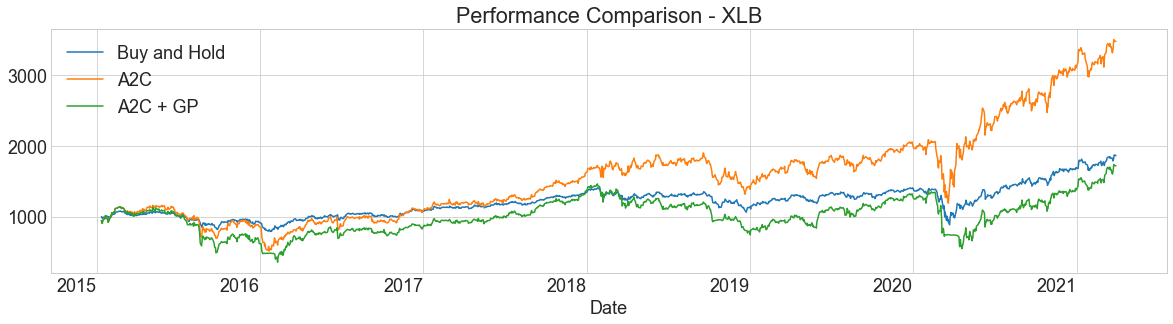

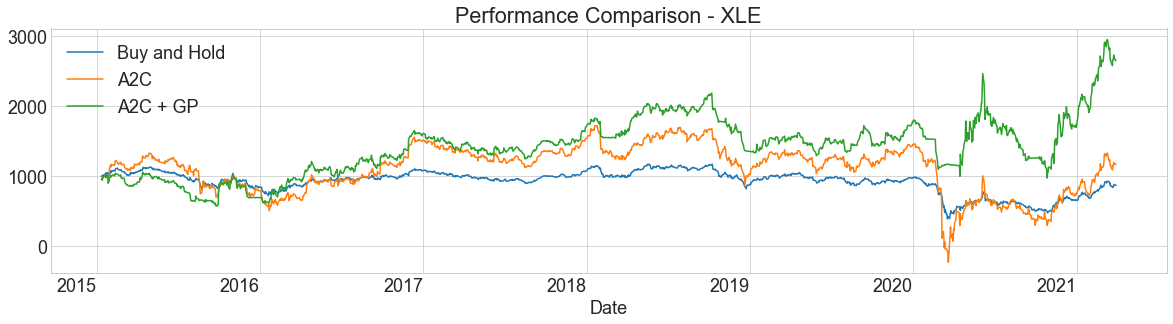

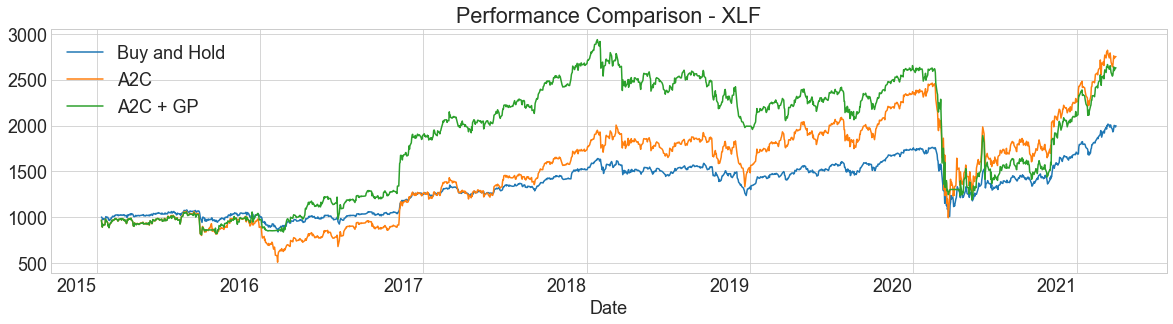

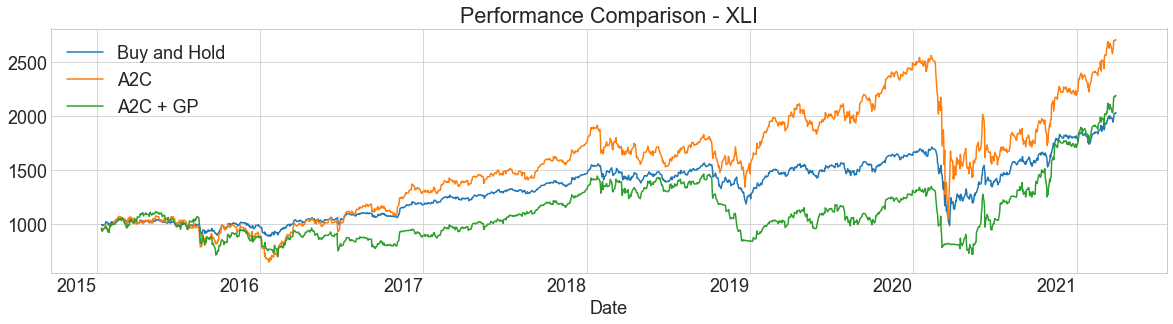

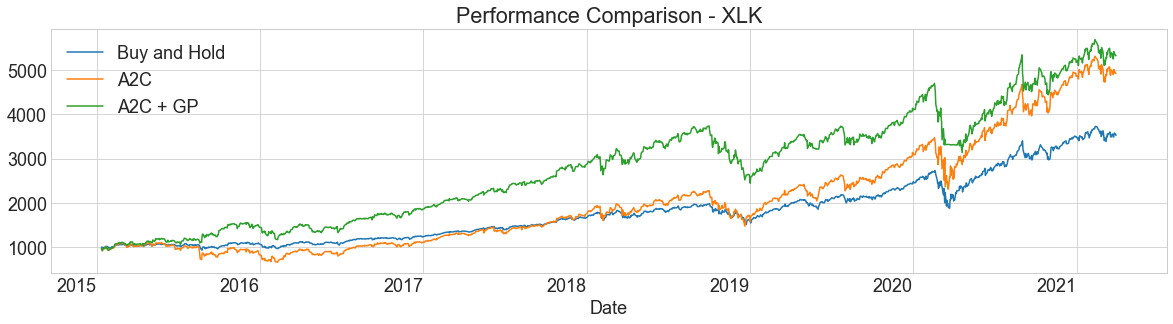

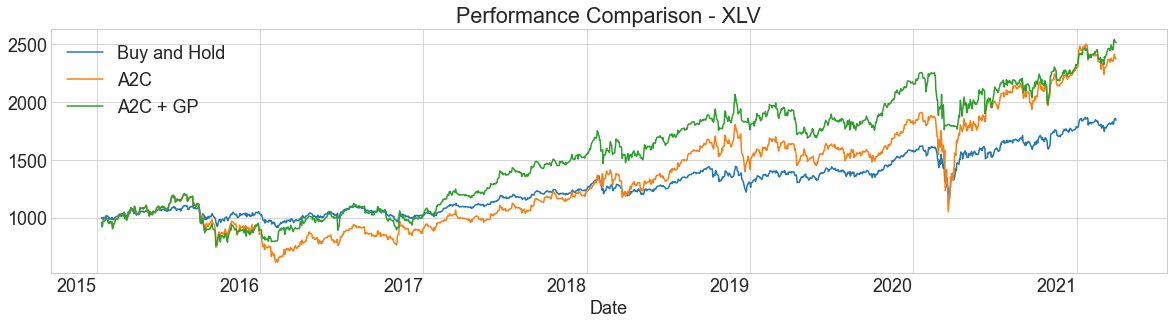

In [190]:
tickers = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLV']
for tic in tickers:
    results = pd.read_csv('../data/{}_results.csv'.format(tic.lower()))
    results['Buy and Hold'] = results['Buy and Hold'] * (1000 / results['Buy and Hold'][0])
    results['Date'] = pd.to_datetime(results['Date'])
    results.set_index('Date', inplace=True)
    fig = results[['Buy and Hold', 'A2C', 'A2C + GP']].plot(figsize=(20,5), 
                                                            title='Performance Comparison - {}'.format(tic),
                                                            rot=0)
    fig.figure.savefig('figures/{}_performance_comparison.pdf'.format(tic.lower()), bbox_inches='tight')
    plt.show()

In [169]:
fig.figure.savefig('figures/spy_drawdowns_comparison.pdf', bbox_inches='tight')

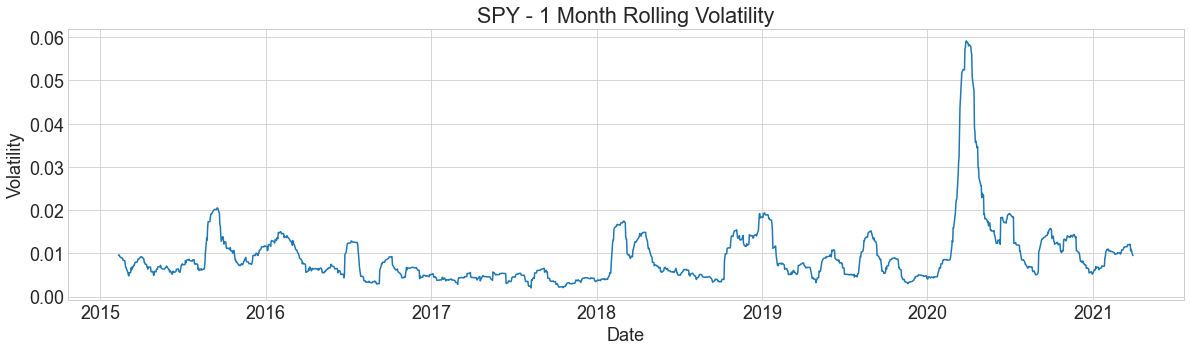

In [185]:
fig = plt.figure(figsize=(20,5))
plt.plot(results.index[1:], pd.Series(np.diff(np.log(results['Buy and Hold']))).rolling(20).std())
plt.title('SPY - 1 Month Rolling Volatility')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [186]:
fig.savefig('figures/spy_volatility.pdf', bbox_inches='tight')

In [148]:
results.shape[0]

1565

In [160]:
# returns = [117.96, -16.31, 98.11, 101.94, 248.08, 84.16]
# returns = [173.65, 16.9, 175.3, 170.19, 392.13, 137.43]
returns = [222.23, 165.05, 163.02, 118.67, 432.39, 151.27]

n_years = results.shape[0] / 252
# print(n_years)
for r in returns:
    print( f'{100*((1 + r/100)**(1/n_years) - 1):.2f}' )

20.73
16.99
16.85
13.43
30.90
15.99
